# Project 2: Fire in the nature park

**University of Potsdam**    
**Jaesub Kim, 824937**    
**2024-08-07**

Developing a model that predicts the burnt forest area

## Data Preperation

In [133]:
import numpy as np
import pandas as pd

original_df = pd.read_csv('fires.csv',sep=',',header=0)
header = original_df.columns
print(header)
original_df.head()

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Data preprocessing

Here, the 'area' data is transformed with `'area' = log(1 + area)`, and checked if there is any missing value in data.

And the categorical variables for day of the week and month will be replaced with numbers.

Here, we dont need to normalize the data, because we are using random forest.


In [163]:
from sklearn.preprocessing import LabelEncoder

# transform the 'area' column to log(area+1)
df = original_df.copy()
original_area = df['area']
df['area'] = np.log(df['area']+1)

print(df)

print("\n-------------------------\n")

# to check if there is any missing value in the data
print(df.isnull().sum())
# no missing data

print("\n-------------------------\n")

num_df = df.copy()

label_encoders = {} # 딕셔너리 초기화
for column in ['month', 'day']:
    label_encoders[column] = LabelEncoder()
    num_df[column] = label_encoders[column].fit_transform(df[column]) # 각 문자열을 정수로 변환. 요일 및 월 등이 자동으로 정수로 변환된다.
    




     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain      area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0  0.000000
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0  0.000000
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0  0.000000
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2  0.000000
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0  0.000000
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...       ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0  2.006871
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  4.012592
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  2.498152
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0  0.000000
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0  0.000000

[517 rows x 13 columns]

-------------------------


## Data Analysis

### Statistics

It is difficult to see at a glance how the data is structured with just `describe()`. Therefore, here we will look into the distribution of the data in detail through a plot. The distribution of all features of the data is shown as a histogram.


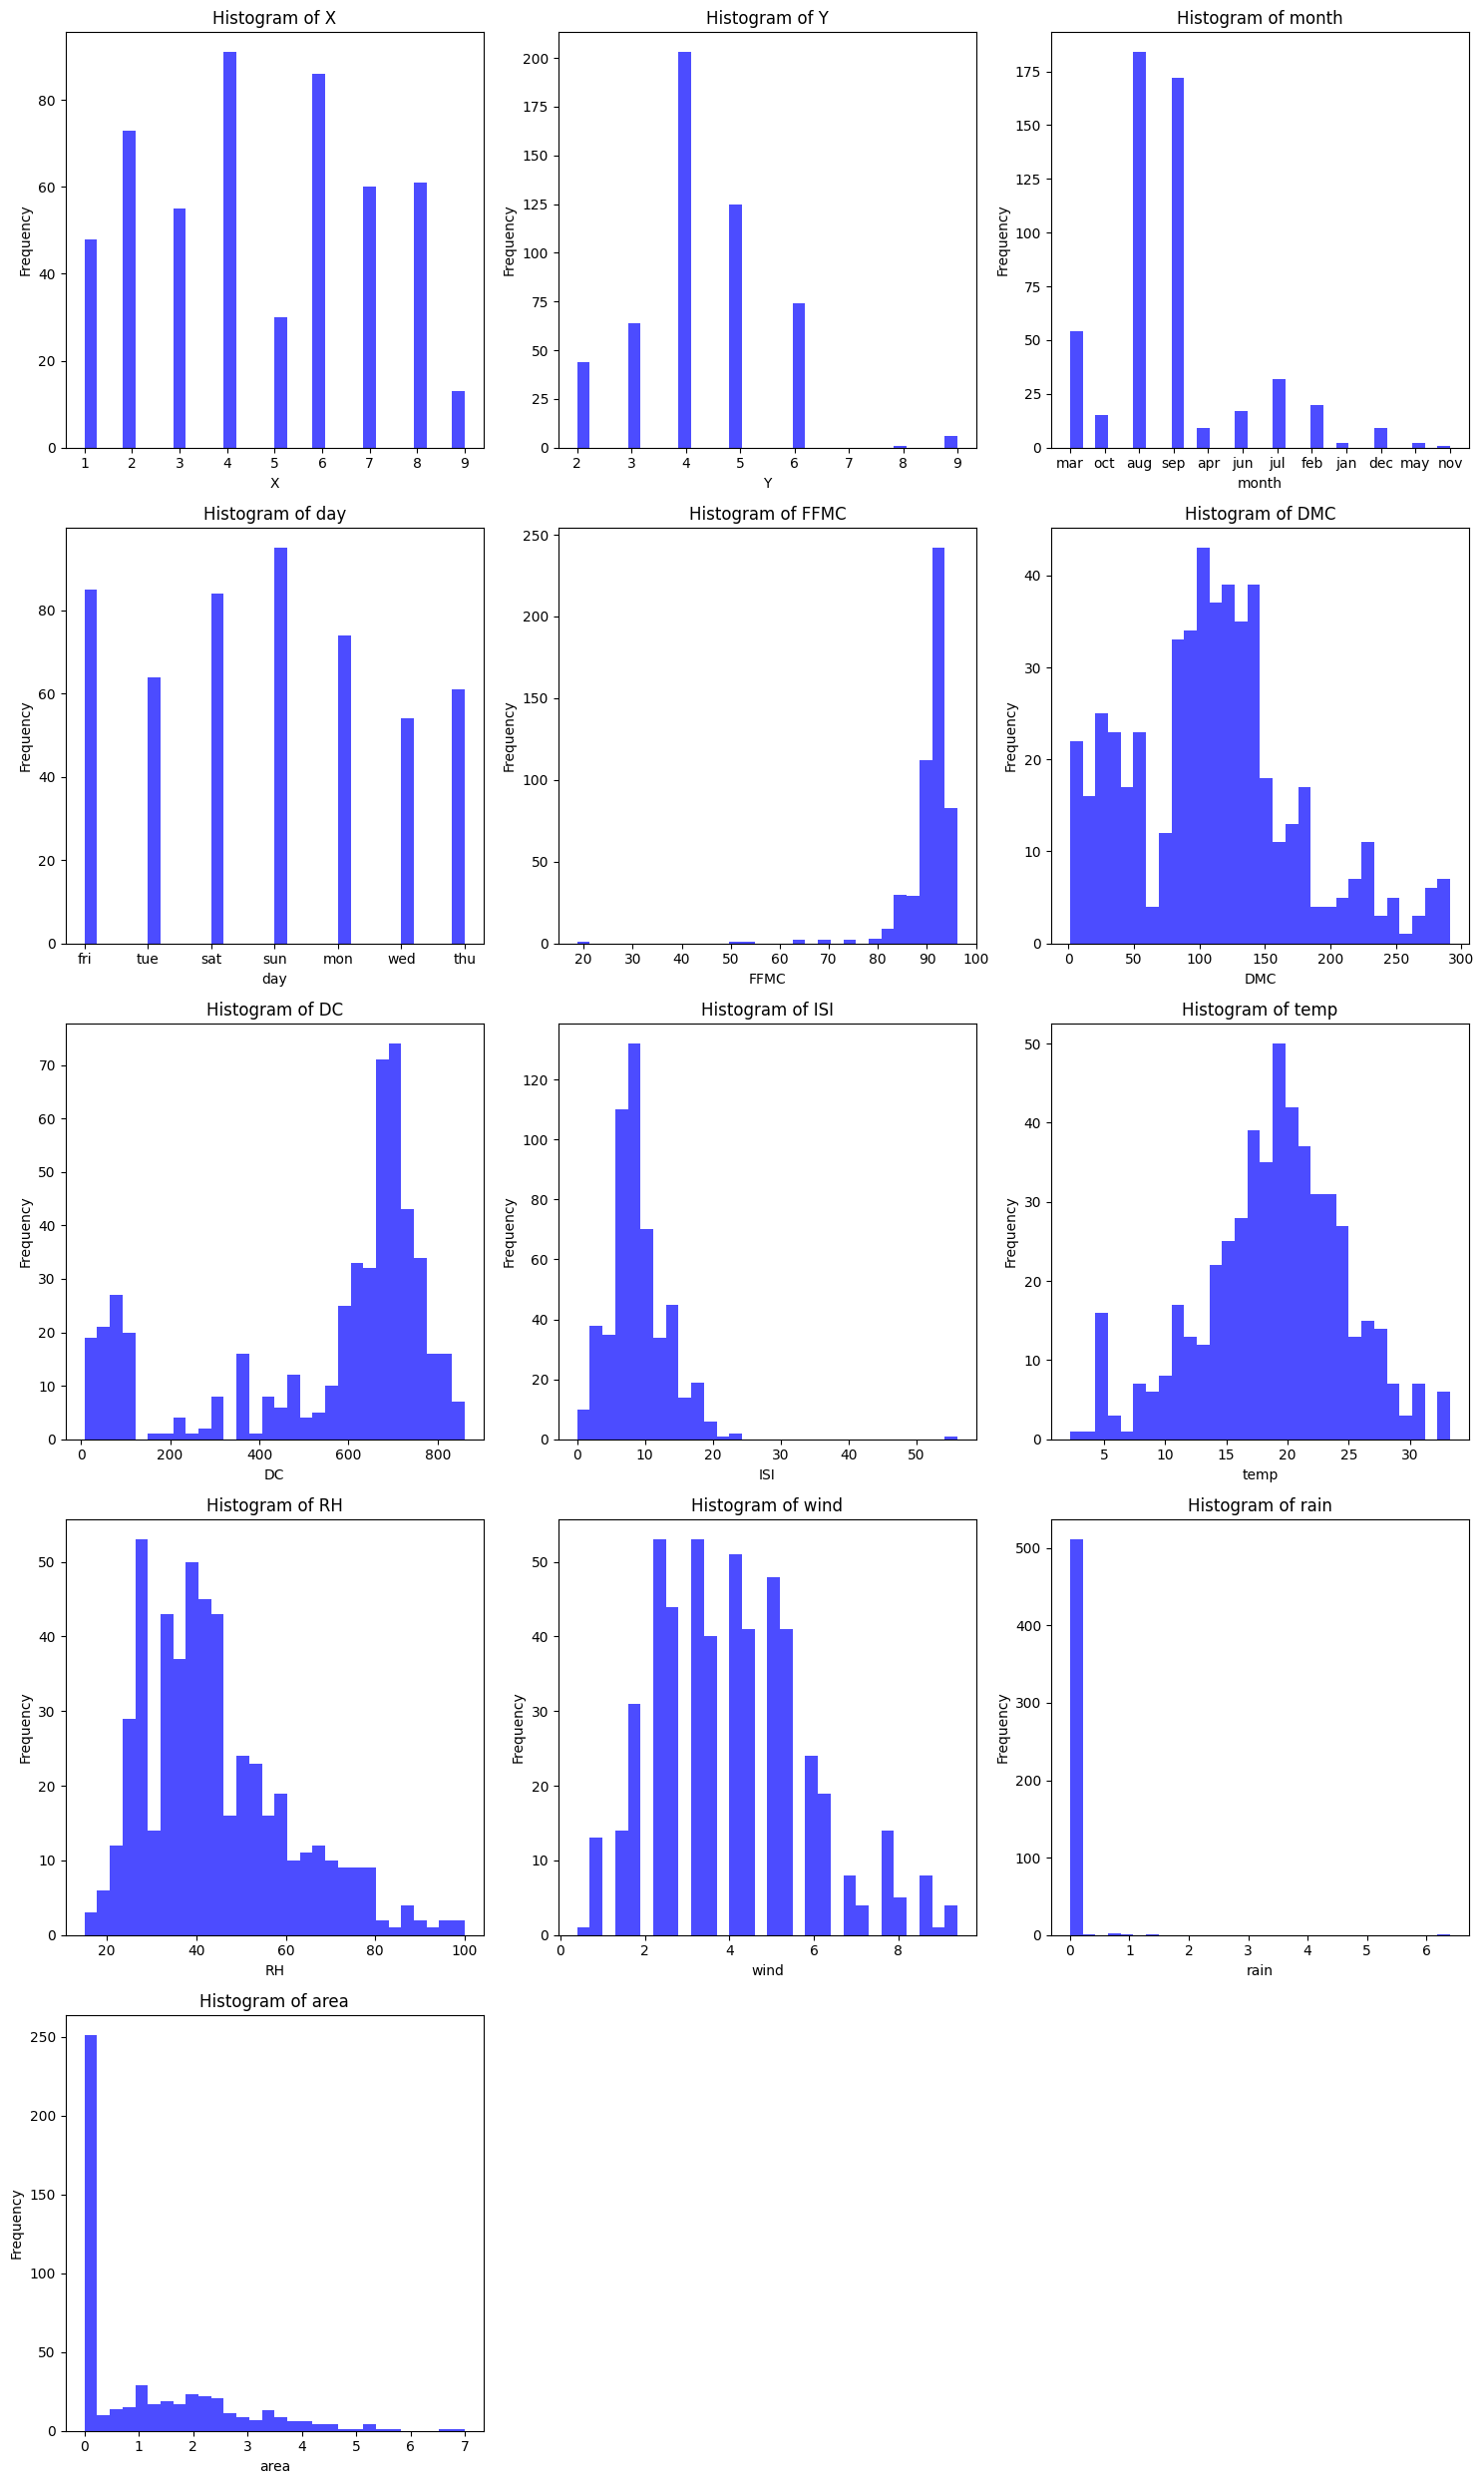

In [168]:
import matplotlib.pyplot as plt

num_features = len(header)
fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))
axes = axes.flatten() # 2차원 배열 형태의 axes를 1차원 배열로 변환. 이렇게 하면 for loop을 사용할 때 편리하다.

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=30, color='blue', alpha=0.7) # bin은 막대 개수
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

# 서브플롯 레이아웃 조정
plt.tight_layout() # 서브플롯 간의 간격을 자동으로 조정
plt.show()


Before analyzing the histogram for each data, we compute measurements that can help describe the distribution. The Mean, STD, Skewness, and Kurtosis of each data are calculated. However, these measurements are not valid for all features.

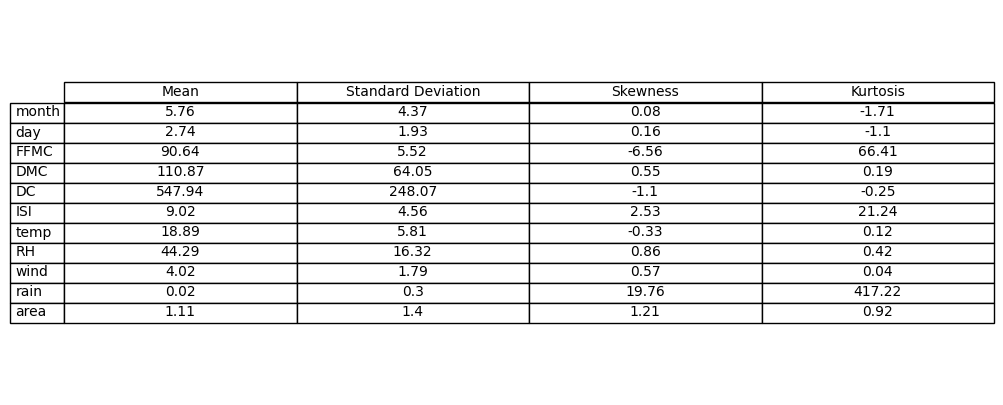

In [132]:
from scipy.stats import skew, kurtosis

def calculate_statistics(data):
    statistics = {
        'Mean': data.mean(),
        'Standard Deviation': data.std(),
        'Skewness': skew(data),
        'Kurtosis': kurtosis(data, fisher=True)
    }
    return statistics

stats = num_df.drop(columns=['X', 'Y']) 
# X and Y are coordinates that indicate location and are therefore judged to be meaningless.

# Calculate statistics for each column
statistics = {column: calculate_statistics(stats[column]) for column in stats.columns}
# 각 열에 대해 통계량을 계산하고, 딕셔너리로 저장
statistics_df = pd.DataFrame(statistics).T  # 딕셔너리를 데이터프레임으로 변환 후 전치

# 시각적으로 보기 좋게 출력
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axis('tight')
ax.axis('off') # 축 숨기기
table = ax.table(cellText=statistics_df.values.round(2), colLabels=statistics_df.columns, rowLabels=statistics_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.show()


Let's take a look at the visible features one by one, starting from the first one. The above statistics will be used in the necessary context.

- **X, Y**: 이들은 산불이 발생한 지역의 좌표이다. 히스토그램으로는 의미있는 정보를 알아보기 어려워, 여기선 제외하였다.

- **Month**: 확실한 bias가 보이며, 산불이 대부분 8월과 9월에 발생하는 것으로 나타났다 (kurtosis = -1.71). 여기서 우리는 확실히 month가 산불 발생을 예측하는데 있어 중요하게 사용될 수 있으리라는 예상해볼 수 있다. 

- **Day**: 산불 발생 빈도는 모든 요일에 고르게 분포하며, 요일이 딱히 크게 영향을 미치는 것 같아 보이지는 않는다. 그러나, 금 토 일의 산불 발생 빈도가 다른 날짜에 비해 아주 약간 높은것이 나타난다. 이에 대해서는 주말 기간의 등산객으로 인한 산불 발생의 영향을 생각해 볼 수 있을 것 같다. 

    ![](./moisture.png)

- **FFMC**: The FFMC is a numerical rating of the moisture content of litter and other cured fine fuels (needles, mosses, twigs less than 1 cm in diameter) . The FFMC is representative of the top litter layer 1-2 cm deep. 0-96값을 가지며 높을수록 건조함을 나타낸다. 86 이상의 값에서 산불 발생의 가능성이 높다고 알려져있다. 이 인덱스는 데이터 상에서 마찬가지로 확실한 skewness를 보여준다.

- **DMC**: This index indicates the moisture content of loosely-compacted organic layers with a depth of 5-10 cm. DMC fuels have a slower drying rate than FFMC fuels and DMC may be used in predicting the probability of fire ignition by lightning. 마찬가지로 값이 높을수록 건조함을 나타낸다. 현재 데이터 상에서는 45-175 사이의 값을 보여주며, 이때 주로 산불이 발생한다는 것을 알려줍니다. 

- **DC**: The third moisture code is the DC, and it is an indicator of moisture content in deep, compact organic layers. This code represents the fuel layer approximately 10-20 cm deep. 위 둘과 마찬가지로 값이 클수록 건조함을 나타내며, 700 값 근처에서 산불 발생이 가장 빈번했던 것으로 나타난다. 

- **ISI**: ISI는 Initial Spread Index를 뜻하며, FFMC와 풍속이 결합되어 예상 화재 확산 속도를 나타낸다. 데이터는 그리 크지 않은 ISI값을 보여준다.

- **temp**: 평균 20도의 선선하고 서늘한 온도를 나타낸다. 산불 발생시점이 8월과 9월에 치우쳐있음에도, 크게 높지 않은 평균 기온을 보여준다.

- **RH**, **Rain**: Relative Humidity를 뜻하며, 왼쪽으로 치우친 분포를 나타낸다. rain의 히스토그램과 연관시켜 볼때, 이는 화재 발생 당시 대부분 건조한 습도에 비가 내리지 않았음을 뜻한다. 

- **wind**: 1 표준편차 거리를 계산했을때, 2.23-5.81 범위 근처의 풍속에서 대부분의 산불이 발생했다. 보퍼트 풍력 5계급으로, 호수에 물결이 일 정도의 강하지 않은 바람이 불 때 산불이 많이 발생했음을 보여준다. 데이터 feature들 중 가장 정규분포에 가까운 분포를 보여준다. 

- **area**: 대부분의 값이 0을 나타낼 정도로, 산불의 확산이 크지 않았음을 나타낸다.  


temp와 wind를 제외하고, 대부분의 features에서 데이터가 무질서하게 분포되어있는 것을 볼 수 있다. 예를 들어, FFMC와 Month의 경우 대부분의 데이터가 좁은 영역에 포함되어있을 정도로 치우침이 심하고, DMC와 DC는 설명하기 힘든 분포를 가진다.


* 출처: https://cfs.nrcan.gc.ca/pubwarehouse/pdfs/23688.pdf


### Location and frequency of fire occurrence

위치와 산불 발생 빈도간의 관계가 있을까? 위의 데이터 분포를 보면, 좌표에 어느정도 치우침이 보인다. 이를 자세히 알아보기 위해, 좌표에 따른 산불 발생 빈도를 히트맵으로 나타내었다. 

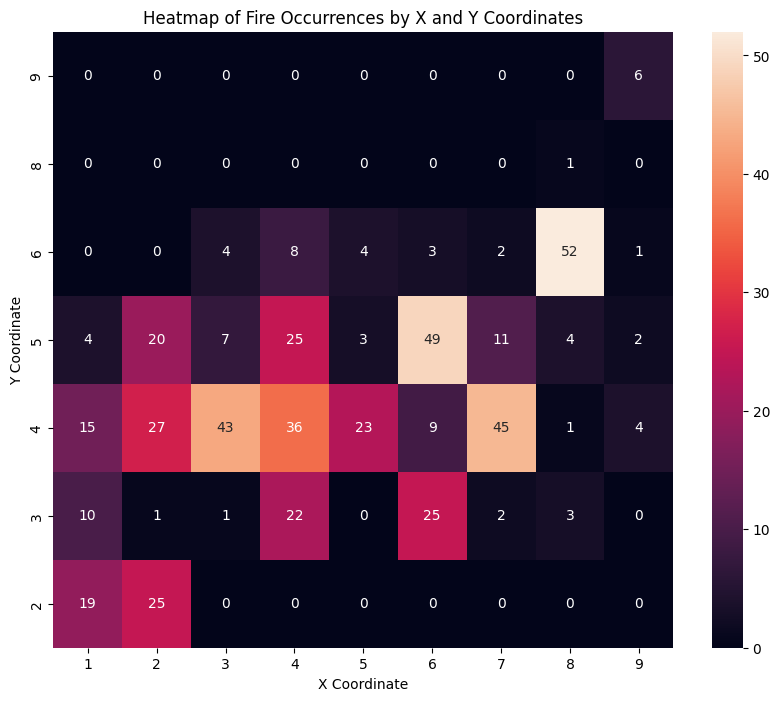

In [94]:
import pandas as pd
import seaborn as sns

# X, Y 좌표를 사용하여 히트맵 생성
heatmap_data = df.pivot_table(index='Y', columns='X', values='area', aggfunc='count', fill_value=0)
# pivot_table 함수는 데이터 프레임을 재구성해 새로운 테이블을 만든다. 
# fill_value: 데이터가 없는 경우, 0으로 채운다. 

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cbar=True) # 아까 만들어두었던 피봇 테이블로 히트맵을 구성한다.
plt.gca().invert_yaxis()  # Y 축 반전
plt.title('Heatmap of Fire Occurrences by X and Y Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

이 히트맵을 통해 가장 화재가 자주 일어나는 지역을 찾을 수 있었다. 데이터엔 분명히 산불이 더 자주 일어나는 지역이 관찰된다. (8,6), (6,5), (7,4) 그리고 (3,4)에서 화재가 가장 빈번히 발생하였다 (n>40).

그러나, 우리 데이터의 문제는, 대부분의 산불 데이터에서 산불로 인한 삼림 소실 영역이 그렇게 크지 않고, 심지어 0으로 나타나는 데이터가 대부분 이라는 것이다. 이는 산불로 인한 피해가 산불의 빈도와 일치하지 않을 가능성을 시사하며, 예측 모델을 트레이닝 하는데 안좋은 영향을 끼칠 수 있다. 따라서, 산불 발생 빈도와 산불로 인한 총 피해의 분포를 파악하기 위해, 소실 면적의 누적 합산을 통해 누적 소실 히트맵을 만들었다. 

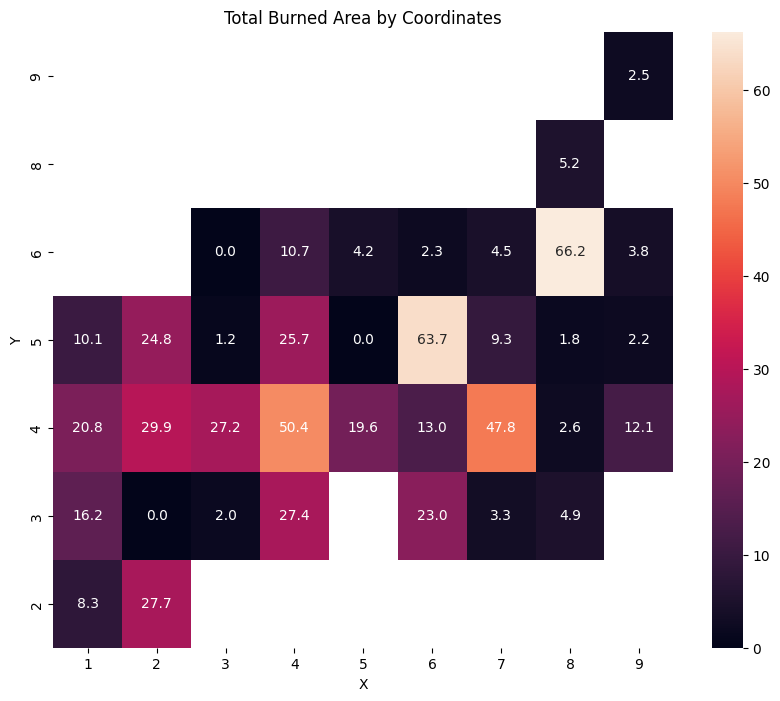

In [95]:
area_sum_by_coordinates = df.groupby(['X', 'Y'])['area'].sum().reset_index()

pivot_table = area_sum_by_coordinates.pivot(index='Y', columns='X', values='area')

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f")
plt.gca().invert_yaxis()  # Y 축 반전
plt.title('Total Burned Area by Coordinates')
plt.show()

다행히도, 누적 피해량 또한 어느정도 일치를 보인다. 이는 X좌표와 Y좌표가 산불 발생과 산림 소실 area의 예측에 큰 도움이 될 수 있다는 점을 시사한다. 

이밖에도, area가 다른 변수들과 어떤 연관성을 보이는지 알기 위해, 상관관계 분석을 시행했다. 이때 area와 다른 feature들과의 상관관계 뿐만 아니라, 각 features 간의 상관관계도 함께 계산하였다. 

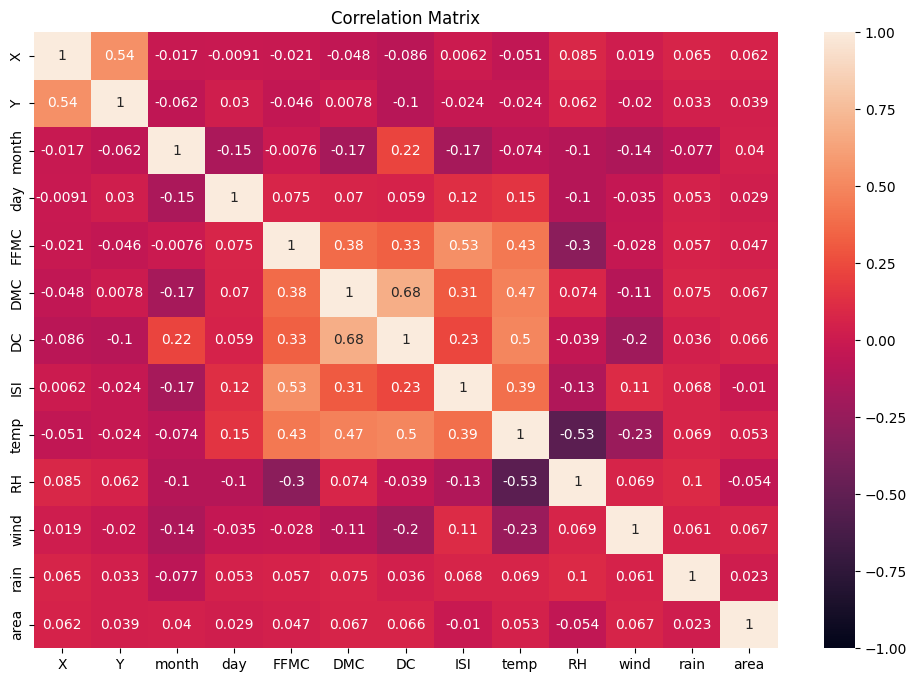

In [96]:
# 상관 행렬 계산
corr_matrix = num_df.corr()

# 상관 행렬 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

놀랍게도, area는 전체적으로 모든 features와 낮은 상관관계를 보이지만, 몇몇 features간에서 강한 상관관계가 포착되었다. 먼저, DMC와 DC가 가장 큰 상관관계를 보이는데, 이는 이 둘이 좁은 높낮이를 차이로 서로 밀접하게 연관이 되어있다는 것을 생각하면 놀랍지 않다. 그러나 이 둘은 FFMC와 상대적으로 낮은 상관관계를 보이는데, FFMC는 표층으로써 외부 바람이나 온도에 의해 쉽게 마를 수 있다는 것을 생각하면 충분히 예상되는 결과이다. 이를 뒷받침 하듯, temperature가 이 세가지 features와 동시에 강한 상관관계를 가지는 것이 확인되었다. Temperature는 이외에도 RH와 강한 음의 상관관계를 가진다.

Area와 다른 features간의 상관관계가 매우 낮다는 것은 이들이 area의 예측에 별로 도움이 되지 않을 것이라는 것을 의미한다. 위에서 이미 언급하였듯 몇가지 주요한 이유가 가능하다:

1. 절대적인 데이터 양의 부족
2. area의 대부분의 값이 0에 가까움

이로 인해 이후 만들어질 모델의 accuracy가 높지 않을 것으로 기대한다.

## Model Selection

now, an appropreate method to train the prediction model must be choosen.

이 프로젝트에서 적절한 학습 방법으로 Random Forest가 선택되었다. 선택의 이유는 다음과 같다:

- 일단 우리의 데이터는 몇가지 범주형 features를 포함한다. 따라서 우리는 Linear Regeression을 사용하지 않는다. 

- SVM은 매우 효과적인 방법이지만, 우리의 데이터는 그리 많은 features를 가지고 있지 않기 때문에, SVM을 사용할 이유가 없다. 

- Neural Networks를 사용하기엔 우리 데이터는 너무 적기에, 효율적으로 학습할 수 없다. 또한 SVM과 Neural Network에 비해 random forest는 결과 해석이 용이하다.

- Decision Tree는 Random Forest에 비해 Overfitting의 위험이 크다. 

- 산불 발생 예측 모델에는 다양한 접근 방식이 사용된다. [Stojanova et al. (2012)](https://doi.org/10.1007/s10618-011-0213-2)는 다양한 변수를 활용하여 산불을 예측하는 KNN, DT, LR, SVM, BN 등의 머신러닝 모델을 비교하여 평가하였다. 이때 RF가 가장 높은 성능을 나타냈으며, [Vecín-Arias et al. (2016)](https://doi.org/10.1016/j.agrformet.2016.05.003)와 [Van Beusekom et al.(2018)](https://doi.org/10.1007/s10584-017-2045-6) 또한 RF 모델이 산불발생을 예측하는데 있어서 다른 모델보다 뛰어난 성능을 보인다고 보고했다. 

- Random Forest는 정규화를 요구하지 않는다. 



## Random Forest 

먼저 독립변수와 종속변수를 분리한 뒤, 테스트 세트와 트레이닝 세트로 데이터를 나눠 랜덤 포레스트를 학습하였다. 

우리의 데이터가 그리 크지 않기 때문에, 모델을 평가할 방법으로 k-fold cross validation을 사용할 것이며, 따라서 훈련세트와 테스트 세트로 나누는 과정이 필요하지 않다. 

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# 독립 변수와 종속 변수 분리
X = num_df.drop('area', axis=1)
y = num_df['area']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
RFmodel = RandomForestRegressor(random_state=42)
RFmodel.fit(X_train, y_train)

# prediction
RF_pred_test = RFmodel.predict(X_test)
RF_pred_train = RFmodel.predict(X_train)

# evaluation
RF_mse = mean_squared_error(y_test, RF_pred_test)
RF_mse_train = mean_squared_error(y_train, RF_pred_train)

results = {
    "Metric": ["Mean Squared Error"],
    "Train": [RF_mse_train],
    "Test": [RF_mse]
}

results_df = pd.DataFrame(results)
print(results_df)

    

               Metric     Train      Test
0  Mean Squared Error  0.305257  2.321695


트레이닝 세트와 테스트 세트간의 MSE에 큰 차이가 보인다. 이는 보통 Overfitting에 의한 것일 수 있는데, Parameter의 변화가 이에 어떤 영향을 미치는지에 대해 알아보기 위해 다음 절차를 진행하였다.

## Parameter estimation

Overfitting은 종종 Parameter tuning으로 해결될 수 있다. 적절한 Parameter를 찾기 위해, 파라미터의 변화에 따른 MSE의 변화를 측정하였다. 가장 주요한 파라미터인 `n_estimators`와 `max_depth`가 테스트되었다. 

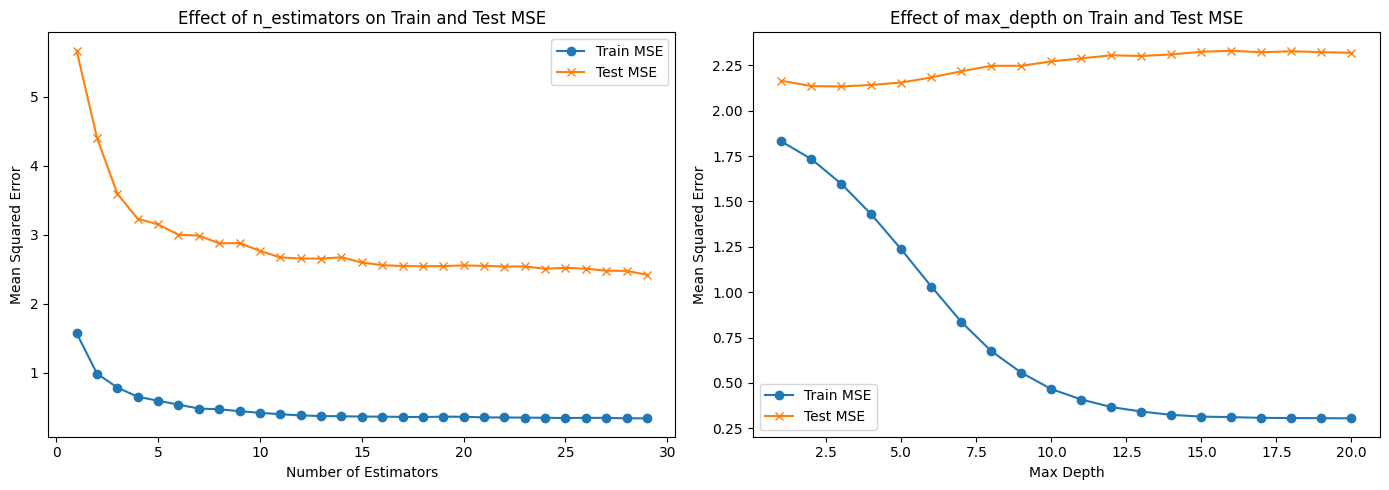

In [173]:
# n_estimators의 변화에 따른 모델 성능 평가. 1-30 사이의 n_estimators 값을 사용
n_estimators_range = range(1, 30)
train_mse_values = []
test_mse_values = []

for n_estimators in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)


# max_depth의 변화에 따른 모델 성능 평가. 1-20 사이의 max_depth 값을 사용
max_depth_range = range(1, 21)
train_accuracies_depth = []
test_accuracies_depth = []

for max_depth in max_depth_range:
    model = RandomForestRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    train_accuracies_depth.append(train_mse)
    test_accuracies_depth.append(test_mse)

# 그래프로 나타냄

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# 첫 번째 그래프: n_estimators에 따른 MSE
axes[0].plot(n_estimators_range, train_mse_values, label='Train MSE', marker='o')
axes[0].plot(n_estimators_range, test_mse_values, label='Test MSE', marker='x')
axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Effect of n_estimators on Train and Test MSE')
axes[0].legend()

# 두 번째 그래프: max_depth에 따른 MSE
axes[1].plot(max_depth_range, train_accuracies_depth, label='Train MSE', marker='o')
axes[1].plot(max_depth_range, test_accuracies_depth, label='Test MSE', marker='x')
axes[1].set_xlabel('Max Depth')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('Effect of max_depth on Train and Test MSE')
axes[1].legend()

plt.tight_layout()
plt.show()

Number of Estimators의 경우에, `n_estimators`가 커질수록 `Train`과 `Test`가 모두 점진적으로 낮아지며, 한 라인에 수렴하는것이 보인다. 점근선과 효율성을 고려하여, `n_estimators = 15`이 선택되었다.

최대 깊이의 경우, `max_depth`가 커질수록 `Test`가 살짝 높아지며 `Train`의 MSE가 빠르게 감소하는것이 관찰되었다. 그러나 이에 반해 `Test`의 MSE 증가폭은 그리 크지 않았으며 (~ 0.1), 이또한 어떠한 값에 수렴하는 것이 관찰되었다. `max_depth = 10`이 선택되었다. 

## Evaluation

### K-fold Cross Validation

얻어진 파라미터를 이용하여 랜덤포레스트를 진행하였다. 모델을 평가하기 위해 5-fold cross validation이 사용되었으며, Mean Predictor와 Medain Predictor를 Baseline Model로 선택하여 비교하였다. 모델의 평가 지표로써는 전통적으로 사용되는 MSE와 $r^2$ score를 사용하였다. 

MSE는 직접적으로 예측값과의 편차를 보여주며, $r^2$ score는 예측된 값과 실제 값 간의 분산을 비교하여 모델의 설명력을 측정한다. 1에 가까울수록 모델이 데이터를 잘 설명함을 의미합니다. 0은 모델이 데이터를 설명하지 못함을, 음수는 모델이 평균보다도 못함을 의미합니다.

In [198]:
from sklearn.model_selection import  cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 설정
RFmodel = RandomForestRegressor(n_estimators= 15, max_depth=10, random_state=42)
baseline_mean = DummyRegressor(strategy='mean')
baseline_median = DummyRegressor(strategy='median')

# 성능 평가를 위한 MSE 스코어러 설정
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

# Random Forest 교차 검증 수행
mse_scores_rf = cross_val_score(RFmodel, X, y, cv=kf, scoring=mse_scorer)
r2_scores_rf = cross_val_score(RFmodel, X, y, cv=kf, scoring=r2_scorer)

# Dummy Regressor 교차 검증 수행
mse_scores_dummy_mean = cross_val_score(baseline_mean, X, y, cv=kf, scoring=mse_scorer)
r2_scores_dummy_mean = cross_val_score(baseline_mean, X, y, cv=kf, scoring=r2_scorer)

mse_scores_dummy_median = cross_val_score(baseline_median, X, y, cv=kf, scoring=mse_scorer)
r2_scores_dummy_median = cross_val_score(baseline_median, X, y, cv=kf, scoring=r2_scorer)

# 교차 검증 결과 출력

comparision = {
    "" : ["MSE", "r2_score"],
    "Random_Forest": [np.mean(mse_scores_rf), np.mean(r2_scores_rf)],
    "Baseline_Mean": [np.mean(mse_scores_dummy_mean), np.mean(r2_scores_dummy_mean)],
    "Baseline_Median": [np.mean(mse_scores_dummy_median), np.mean(r2_scores_dummy_median)]
}

print(round(pd.DataFrame(comparision),2))



             Random_Forest  Baseline_Mean  Baseline_Median
0       MSE           2.21           1.95             2.42
1  r2_score          -0.14          -0.00            -0.25


보통 baseline model의 정확도 혹은 MSE보다 더 나은 값이 나왔을때 우리는 이 모델이 좋은 예측을 한다고 평가한다. 그러나 우리 Random Forest모델을 baseline 모델의 mean과 median 예측값과 비교해본 결과, Median보다는 성능이 나았지만 크게 좋지 않았고, Mean보다는 성능이 뒤쳐졌다. 또한 전체적으로 세 모델의 MSE가 비슷비슷 했다. 

또한 $r^2$ score는 Random Forest에서 음수값으로 나타나 모델이 좋지 않음을 나타냅니다. 

처음 모델의 성능이 좋지 않을 것이라고 예측한 대로, 우리의 예측 모델은 좋은 성능을 보이지 않아 보인다.

### Feature Importances

각각의 features가 예측에 얼마나 기여했는지 살펴보기 위해, Feature importances를 계산하여 히스토그램으로 표현했다. 

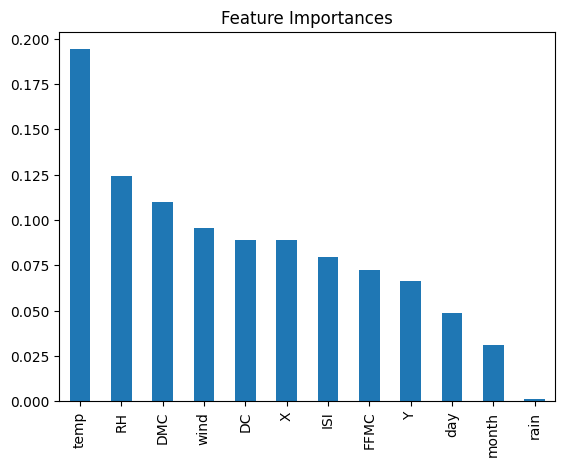

In [187]:
clf_importances = pd.Series(feature_importances, index=X.columns)
clf_importances = clf_importances.sort_values(ascending=False)
clf_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()


예측에 가장 중요한 역할을 한 features는 `temp`, `RH` and `DMC` 등으로 나타났다. 그 중 `temp`가 특히 많은 기여를 한 것으로 보인다. 

Temperature는 초기에 데이터상에서 그리 높지 않고, 정규분포를 나타내어 산불 발생에 큰 영향이 없을것이라고 생각되었다. 그러나 위 히스토그램에선 `temp` feature가 예측에 가장 큰 기여를 한것으로 나타난다. 이는 위의 features간의 상관관계를 나타내는 히트맵을 참고하였을때, 여기서 `temp`를 제외하고 가장 큰 영향을 미친 RH 및 DMC, DC 등과 강한 상관관계를 가지고 있다는 것으로 이 결과를 설명할 수 있다. 

초기에 직관적으로 가장 큰 영향을 미칠 것이라고 생각되었던 `month`가 `rain` 다음으로 가장 낮은 기여를 보이고 있는 것으로 나타났다(심지어 `day`보다 낮음). `Month`, `rain`, `FFMC`의 예상보다 낮은 기여도는 이들의 분포로 설명될 수 있다. 주어진 데이터에서, 이들의 분포는 좁은 영역에 대부분의 데이터가 모여있는 극단적인 치우침의 형태를 나타내는데, 이러한 분포를 가지는 데이터는 정보량이 적고 변별력이 낮아 예측에 있어서는 중요도 있게 사용되기 어렵다.

또한, 이런 데이터는 어쩌면 산불 발생의 주요한 특징이 될 수 있지만, 우리 목적은 산불의 발생을 예측하는 것이 아니라 area를 예측하는 것이기 때문에, 여기서는 prediction에 크게 기여하지 않은 것으로 추측된다. 

## Other approaches

데이터 처리 및 예측 방식에 있어 몇가지를 더 시도해 볼 수 있다. 

### One-hot Encoding

날짜와 월 같은 범주형 데이터들은 Regression에 사용하기 위해 숫자로 변형되어 사용됩니다. 그러나 종종 이것이 문제를 일으킬 수 있습니다. 예를 들어, 날짜와 월 데이터는 순서를 가지지 않습니다. 그러나 이들을 숫자로 변형하는 것은 이들에게 순서를 부여하여 모델로 하여금 잘못 트레이닝 되는 결과를 야기할 수 있습니다. 

우리 모델의 결과값이 그닥 좋게 나오지 않았고, 어쩌면 이것이 영향을 미쳤을지 모릅니다. 이를 확인하기 위하여 요일과 월을 원핫 인코딩하여 사용하였습니다. 


In [189]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 원-핫 인코딩
one_hot_encoder = OneHotEncoder()
transformer = ColumnTransformer(
    transformers=[
        ('month_day', one_hot_encoder, ['month', 'day'])
    ],
    remainder='passthrough'
)

df_encoded = transformer.fit_transform(df)

# 인코딩된 데이터프레임을 다시 데이터프레임으로 변환
encoded_columns = transformer.named_transformers_['month_day'].get_feature_names_out(['month', 'day'])
all_columns = np.append(encoded_columns, df.columns.drop(['month', 'day']).values)
df_encoded = pd.DataFrame(df_encoded, columns=all_columns)

# 독립 변수와 종속 변수 분리
hot_X = df_encoded.drop(['area'], axis=1)
hot_y = df[['area']]

# 데이터 분리
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(hot_X, hot_y, test_size=0.2, random_state=0)

# 랜덤 포레스트 모델 학습 및 평가
hot_model = RandomForestRegressor(n_estimators=15,max_depth=10, random_state=42)

mse_scores_hot = cross_val_score(hot_model, X, y, cv=kf, scoring=mse_scorer)
print(round(np.mean(mse_scores_hot),2))

2.21


큰 차이를 보이지 않습니다.


### Multi-prediction

특정 위치의 산불 발생 빈도가 높다는 것을 사용하여, 우리는 `area`뿐 아니라 화재의 발생 위치 또한 예측할 수 있다. multioutput regressor를 사용하여, 여러 종속 변수를 예측할 수 있다.  여기서는 k-fold가 아닌 `test`의 MSE를 직접 계산했습니다. 


In [192]:
from sklearn.multioutput import MultiOutputRegressor


# 독립 변수와 종속 변수 분리
X_multi = num_df.drop(['area', 'X', 'Y'], axis=1)
y_multi = num_df[['area', 'X', 'Y']]

# 데이터 분리
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=0)

# MultiOutputRegressor 사용하여 랜덤 포레스트 모델 학습 및 평가
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train_multi, y_train_multi)

# 예측 수행
y_pred_multi = model.predict(X_test_multi)

# 모델 평가
mse_area_multi = mean_squared_error(y_test_multi['area'], y_pred_multi[:, 0])
mse_X_multi = mean_squared_error(y_test_multi['X'], y_pred_multi[:, 1])
mse_Y_multi = mean_squared_error(y_test_multi['Y'], y_pred_multi[:, 2])

print('Location and Area Prediction using RF multi output regressor:')
print('MSE (area): %f' % mse_area_multi)
print('MSE (X): %f' % mse_X_multi)
print('MSE (Y): %f' % mse_Y_multi)



Location and Area Prediction using RF multi output regressor:
MSE (area): 2.689434
MSE (X): 6.066641
MSE (Y): 1.940732


## Transform to Classification

오리지널 데이터상에서 나타나는 소실 면적의 값은 사실 굉장히 넓은 값을 가지고 있다. 데이터의 양이 그렇게 많지 않은데 비해 넓은 범위는 MSE로 나타나는 모델의 성능에 부정적 영향을 끼칠 수 밖에 없다. 

그러나 log transformation 이후 대부분의 소실 면적이 0에 가깝게 나타나는 이상, 우리는 소실 면적을 정확히 예측하는 것에서 벗어나 화재로 인한 피해가 클것인지 작을것인지 classify 하는 방법도 사용할 수 있을 것이다. 이렇게 된다면, 우리 모델의 정확성은 크게 올라갈 것이다. 이를 위해 평균값, 혹은 Median 값을 기준으로 'small'과 'big'으로 나누거나, 여러개의 좁음, 중간, 넓음 등으로 세분화 시켜 여러개의 클래스로 나눠 classification을 진행할 수도 있을 것이다. 

여기선 이러한 데이터를 구현해보겠다.


In [196]:
from sklearn.ensemble import RandomForestClassifier

bins = [0, 1, 2, 3, np.inf]  # 원하는 범위로 설정
labels = ['no demage', 'small', 'big', 'disater']  

category_num_df = num_df.copy()
category_num_df['area'] = pd.cut(num_df['area'], bins=bins, labels=labels, right=False)
#print(category_num_df)

# 독립 변수와 종속 변수 분리
X_cat = category_num_df.drop(['area'], axis=1)
y_cat = category_num_df['area']

# 모델 학습
RFmodel_cat = RandomForestClassifier(n_estimators=15,max_depth=10,random_state=42)


scores_cat = cross_val_score(RFmodel_cat, X_cat, y_cat, cv=kf, scoring='accuracy')
print(f'Mean accuracy: {scores_cat.mean():.2f}')



Mean accuracy: 0.54


딱히 나아지지 않는다. 